In [1]:
# ⽹络中的⽹络（NiN）
''' 
LeNet、AlexNet和VGG都有⼀个共同的设计模式：通过⼀系列的卷积层与汇聚层来提取空间结构特征；然后
通过全连接层对特征的表征进⾏处理。AlexNet和VGG对LeNet的改进主要在于如何扩⼤和加深这两个模块。
或者，可以想象在这个过程的早期使⽤全连接层。然⽽，如果使⽤了全连接层，可能会完全放弃表征的空
间结构。⽹络中的⽹络（NiN）提供了⼀个⾮常简单的解决⽅案：在每个像素的通道上分别使⽤多层感知机
--------------------------------------------------------------------------------------
NiN块:
回想⼀下，卷积层的输⼊和输出由四维张量组成，张量的每个轴分别对应样本、通道、⾼度和宽度。另外，
全连接层的输⼊和输出通常是分别对应于样本和特征的⼆维张量。NiN的想法是在每个像素位置（针对每个
⾼度和宽度）应⽤⼀个全连接层。如果我们将权重连接到每个空间位置，我们可以将其视为1 × 1卷积层（如
6.4节中所述），或作为在每个像素位置上独⽴作⽤的全连接层。从另⼀个⻆度看，即将空间维度中的每个像
素视为单个样本，将通道维度视为不同特征（feature）。
图7.3.1说明了VGG和NiN及它们的块之间主要架构差异。NiN块以⼀个普通卷积层开始，后⾯是两个1 × 1的
卷积层。这两个1 × 1卷积层充当带有ReLU激活函数的逐像素全连接层。第⼀层的卷积窗⼝形状通常由⽤⼾
设置。随后的卷积窗⼝形状固定为1 × 1。
'''
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# NiN块以⼀个普通卷积层开始(卷积窗口由用户设置)，
# 后⾯是两个固定为1 × 1的卷积层(充当带有ReLU激活函数的逐像素全连接层)
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [3]:
# NiN模型
''' 
最初的NiN⽹络是在AlexNet后不久提出的，显然从中得到了⼀些启⽰。NiN使⽤窗⼝形状为11×11、5×5和3×
3的卷积层，输出通道数量与AlexNet中的相同。每个NiN块后有⼀个最⼤汇聚层，汇聚窗⼝形状为3 × 3，步
幅为2。
NiN和AlexNet之间的⼀个显著区别是NiN完全取消了全连接层。相反，NiN使⽤⼀个NiN块，其输出通道数等
于标签类别的数量。最后放⼀个全局平均汇聚层（global average pooling layer），⽣成⼀个对数⼏率（logits）
NiN设计的⼀个优点是，它显著减少了模型所需参数的数量。然⽽，在实践中，这种设计有时会增加训练模
型的时间。
'''
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10,输出通道数量标签类别数
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),  # output size of 1x1 -> torch.Size([1, 10, 1, 1])
    # 全局平均池化层(对由多个输入平面组成的输入信号应用2D自适应平均池化)
    # 将四维的输出转成⼆维的输出，其形状为(批量⼤⼩,10)
    nn.Flatten()) #  -> torch.Size([1, 10])  一个输出,10个特征

In [4]:
# 我们创建⼀个数据样本来查看每个块的输出形状。
X = torch.rand(size=(1, 1, 224, 224)) # 批量 通道 高 宽
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.353, train acc 0.869, test acc 0.874
1689.9 examples/sec on cuda:0


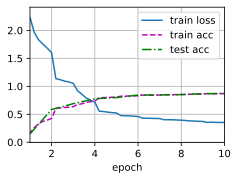

In [5]:
# 训练模型
'和以前⼀样，我们使⽤Fashion-MNIST来训练模型。训练NiN与训练AlexNet、VGG时相似'
lr, num_epochs, batch_size = 0.1, 10, 128
# resize=224,将28x28的分辨率增加到224x224
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224) 
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
''' 
⼩结
• NiN使⽤由⼀个卷积层和多个1 × 1卷积层组成的块。该块可以在卷积神经⽹络中使⽤，以允许更多的每
像素⾮线性。
• NiN去除了容易造成过拟合的全连接层，将它们替换为全局平均汇聚层（即在所有位置上进⾏求和）。该
汇聚层通道数量为所需的输出数量（例如，Fashion-MNIST的输出为10）。
• 移除全连接层可减少过拟合，同时显著减少NiN的参数。
• NiN的设计影响了许多后续卷积神经⽹络的设计。
'''